      time     cpu     cmu     amu  ...     mdit     mldsu    mcui    scui
0        0  0.0189  0.0232  0.0293  ...  0.00181  0.000122  0.0781  0.0105
1        1  0.0189  0.0232  0.0293  ...  0.00181  0.000122  0.0781  0.0105
2        2  0.0189  0.0232  0.0293  ...  0.00181  0.000122  0.0781  0.0105
3        3  0.0189  0.0232  0.0293  ...  0.00181  0.000122  0.0781  0.0105
4        4  0.0189  0.0232  0.0293  ...  0.00181  0.000122  0.0781  0.0105
...    ...     ...     ...     ...  ...      ...       ...     ...     ...
2095  2095  0.0201  0.0228  0.0289  ...  0.00295  0.000120  0.0833  0.0110
2096  2096  0.0201  0.0228  0.0288  ...  0.00295  0.000120  0.0833  0.0110
2097  2097  0.0201  0.0228  0.0288  ...  0.00295  0.000120  0.0833  0.0110
2098  2098  0.0200  0.0228  0.0288  ...  0.00295  0.000120  0.0832  0.0110
2099  2099  0.0200  0.0228  0.0288  ...  0.00295  0.000120  0.0832  0.0110

[2100 rows x 11 columns]
Epoch 1/100
28/28 - 1s - loss: 0.0434 - mse: 0.0869 - val_loss: 0.0150 - v

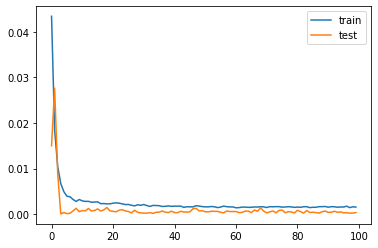

Test RMSE: 0.02509225
Test MSE: 0.00062962


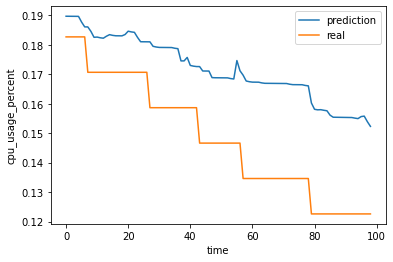

In [2]:
# -*-coding:utf-8-*-
from math import sqrt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GRU
from tensorflow.keras.losses import mean_squared_error
from numpy.core._multiarray_umath import concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer


# supervised监督学习函数


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg


dataset = pd.read_csv(
    'test_data_inversed.csv')

dataset_columns = dataset.columns
values = dataset.values
print(dataset)

# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# 监督学习
reframed = series_to_supervised(scaled, dataset_columns, 1, 1)
values = reframed.values

# 学习与检测数据的划分
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# 监督学习结果划分
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# 为了在LSTM中应用该数据，需要将其格式转化为3D format，即[Samples, timesteps, features]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5,
                 strides=1, padding="causal",
                 activation="relu"))
model.add(
    GRU(
        32,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(GRU(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])
history = model.fit(
    train_X,
    train_y,
    epochs=100,
    batch_size=72,
    validation_data=(
        test_X,
        test_y),
    verbose=2)

# 画图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make the prediction
yHat = model.predict(test_X)

inv_yHat = concatenate((yHat, test_x[:, 1:]), axis=1)   # 数组拼接
inv_yHat = inv_yHat[:, 0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = inv_y[:, 0]

rmse = sqrt(mean_squared_error(inv_yHat, inv_y))
print('Test RMSE: %.8f' % rmse)
mse = mean_squared_error(inv_yHat, inv_y)
print('Test MSE: %.8f' % mse)

yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = inv_yhat[:, 0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = inv_y[:, 0]
plt.plot(inv_yhat, label='prediction')
plt.plot(inv_y, label='real')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()
